# Project Overview

This python notebook is part of my capstone project for the Data Science Nanodegree from Udacity. The provided data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once in a while Starbucks sends offers to their customers through different channels, e.g. Email or Social Media. These offers vary for different users and range from simple advertisements up to discounts like "buy one get one free".

# Problem Statement

The problem I chose to solve is to predict if a customer will respond to an offer. To achieve this, I will train a model with a combination of the transaction and profile data. Since the provided data set does not offer an easy access to the data needed I will create a new Dataframe with all viewed offers and their corresponding completion status and will merge that with the customer profile data and the data for the given offer.

# Metrics

I will use accuracy and the F1-score to evaluate my model, although accuracy does not work well for imbalanced data sets. The F1-score on the other hand is the harmonic mean of precision and recall. Precision measures how good the classifier prevents false negatives and recall measures how good the classifier finds all positive samples. Therefore I will focus on the F1-score.

# Data Exploration & Cleanse

### First View

The provided data set consists of three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

#### Imports & read files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Portfolio

This file contains information about the offers, e.g. which channels were used and the offer type.

In [3]:
portfolio.shape[0]

10

In [4]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


* id (string) - offer id
* offer_type (string) - type of offer i.e. BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

#### Profile

The profile contains information about the users, e.g. age, gender and a user id.

In [5]:
profile.shape[0]

17000

In [6]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

#### Transcript

The transcript contains transaction data of all users. It has an event column, which describes the action that happend, a user id, a time stamp and a value, which has a different structure depending on the event.

In [7]:
transcript.shape[0]

306534

In [8]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### Transcript of a single person

When filtered to a specific user id you get the transaction history of a single user:

In [9]:
transcript[transcript["person"] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


#### Corresponding profile entry

Using the same user id on the profile dataframe returns the information about the user:

In [10]:
profile[profile["id"] == '78afa995795e4d85b5d9ceeca43f5fef']

,gender,age,id,became_member_on,income
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0


### Clean portfolio data

Since the portfolio data set is already in a good shape, I will only rename the "id" column to "offer_id" to make the name more specific and create dummies for the offer type and channels:

In [11]:
cleaned_portfolio = portfolio.copy(deep=True)

In [12]:
cleaned_portfolio = cleaned_portfolio.rename(columns={'id': 'offer_id'})

In [13]:
cleaned_portfolio = pd.get_dummies(cleaned_portfolio, columns=['offer_type'])

In [14]:
cleaned_portfolio = pd.concat([cleaned_portfolio,pd.get_dummies(cleaned_portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)], axis = 1).drop(columns=['channels'])

In [15]:
cleaned_portfolio.head(10)

,reward,difficulty,duration,offer_id,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


### Clean profile data

The profile data contains 17000 user profiles. The .head method already showed, that there is a lot of missing data. I will drop these rows since we need a full profile to train the model. I will also rename the "id" column to "user_id" to make it more specific and will create dummies for "gender" and "became_member_on". To reduce the variance in "became_member_on" I will only use the year and cut the month and day part:

In [16]:
cleaned_profile = profile.copy(deep=True)

In [17]:
cleaned_profile = cleaned_profile.rename(columns={'id': 'user_id'})

In [18]:
cleaned_profile = cleaned_profile.dropna()

In [19]:
cleaned_profile['became_member_on'] = cleaned_profile['became_member_on'].astype(str).str[:4]

In [20]:
cleaned_profile = pd.get_dummies(cleaned_profile, columns=['gender','became_member_on'])

In [21]:
cleaned_profile.head(10)

,age,user_id,income,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,0,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,0,0,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,0,0,0,0,0,1
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,0,0,0,0,0,1
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,0,0,0,0,1,0
13,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1,0,0,0,0,0,0,1,0
14,26,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,0,1,0,0,1,0,0,0,0
15,62,31dda685af34476cad5bc968bdb01c53,71000.0,1,0,0,0,0,0,1,0,0
16,49,62cf5e10845442329191fc246e7bcea3,52000.0,0,1,0,0,1,0,0,0,0
18,57,6445de3b47274c759400cd68131d91b4,42000.0,0,1,0,0,0,0,0,1,0


Profile data is always interesting to analyze and gives insight into the user base, so I will plot histograms for the most interesting values:

<AxesSubplot:>

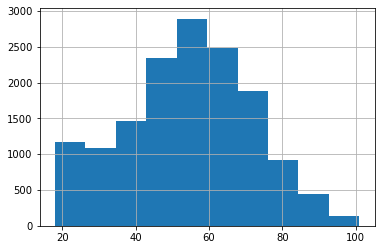

In [22]:
cleaned_profile['age'].hist(bins=10)

<AxesSubplot:>

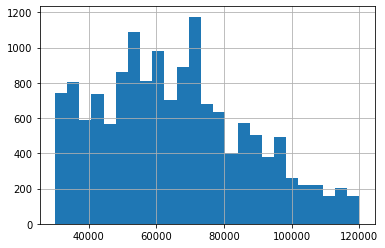

In [23]:
cleaned_profile['income'].hist(bins=25)

<AxesSubplot:>

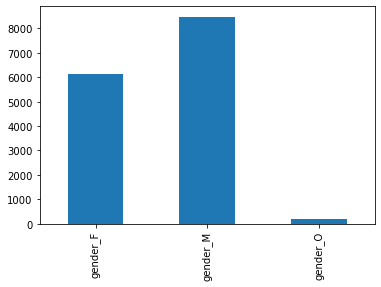

In [24]:
cleaned_profile[['gender_F','gender_M','gender_O']].sum(axis=0).plot.bar()

The age peaks around 50 to 60 years, the majority earns less than 80000$ and there are more men than woman among the users.

### Clean transcript data

The transript is the most challanging data set because "value" has a different structure depending the the event type. If the event is "transaction" the value is stores an amount ("{'amount': 23.93}") and otherwise the value stores an offer id ("{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}"). 
I will create a new column to store the amount separately from the offer id and remove the json structure:

In [25]:
cleaned_transcript = transcript.copy(deep=True)

In [26]:
cleaned_transcript["amount"] = cleaned_transcript["value"]

In [27]:
cleaned_transcript.loc[cleaned_transcript["event"] != "transaction", "amount"] = None
cleaned_transcript['amount'] = cleaned_transcript['amount'].astype(str).str[11:-1]
cleaned_transcript.loc[cleaned_transcript["event"] != "transaction", "amount"] = None
cleaned_transcript['amount'] = cleaned_transcript['amount'].astype(float)

In [28]:
cleaned_transcript.loc[cleaned_transcript["event"] == "transaction", "value"] = None
cleaned_transcript.loc[cleaned_transcript["event"] == "offer completed", "value"] = cleaned_transcript['value'].astype(str).str[14:-15]
cleaned_transcript.loc[cleaned_transcript["event"] != "offer completed", "value"] = cleaned_transcript['value'].astype(str).str[14:-2]


The column "value" now holds the offer ids. Unfortunatly some of the values are using double quotes instead of single quotes. I will replace the double quotes with single quotes:

In [29]:
print(cleaned_transcript['value'].unique())

['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' ''
 "ae264e3637204a6fb9bb56bc8210ddfd'" "4d5c57ea9a6940dd891ad53e9dbe8da0'"]


In [30]:
cleaned_transcript["value"] = cleaned_transcript["value"].str.replace('\'','')

In [31]:
print(cleaned_transcript['value'].unique())

['9b98b8c7a33c4b65b9aebfe6a799e6d9' '0b1e1539f2cc45b7b9fa7c272da2e1d7'
 '2906b810c7d4411798c6938adc9daaa5' 'fafdcd668e3743c1bb461111dcafc2a4'
 '4d5c57ea9a6940dd891ad53e9dbe8da0' 'f19421c1d4aa40978ebb69ca19b0e20d'
 '2298d6c36e964ae4a3e7e9706d1fb8c2' '3f207df678b143eea3cee63160fa8bed'
 'ae264e3637204a6fb9bb56bc8210ddfd' '5a8bc65990b245e5a138643cd4eb9837' '']


I will also rename the column "person" to "user_id" and "value" to "offer_id":

In [32]:
cleaned_transcript = cleaned_transcript.rename(columns={'person': 'user_id', 'value': 'offer_id'})

Since I'm only interested in transactions from users with a full profile I will match the user ids to the user ids left in the cleaned profile data:

In [33]:
print(cleaned_profile['user_id'].unique().shape)
print(cleaned_transcript['user_id'].unique().shape)

#remove all rows with dropped user ids
cleaned_transcript = cleaned_transcript[cleaned_transcript['user_id'].isin(cleaned_profile['user_id'].unique())]

print(cleaned_transcript['user_id'].unique().shape)

(14825,)
(17000,)
(14825,)


In [34]:
cleaned_transcript.head(10)

,user_id,event,offer_id,time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,3f207df678b143eea3cee63160fa8bed,0,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN
9,31dda685af34476cad5bc968bdb01c53,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN
12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,ae264e3637204a6fb9bb56bc8210ddfd,0,NaN
13,c27e0d6ab72c455a8bb66d980963de60,offer received,3f207df678b143eea3cee63160fa8bed,0,NaN
14,d53717f5400c4e84affdaeda9dd926b3,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,NaN
15,f806632c011441378d4646567f357a21,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,NaN


In [35]:
cleaned_transcript[cleaned_transcript["user_id"] == '78afa995795e4d85b5d9ceeca43f5fef']

,user_id,event,offer_id,time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,,132,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,NaN
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,,144,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,5a8bc65990b245e5a138643cd4eb9837,216,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,,222,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,,240,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,,378,23.93


# Preprocess and merge data 

#### Create offer based transcript dataframe

To prepare the data to be used for training a model I will create a new Dataframe that stores a user id, an offer id and a bool value that indicates whether an offer was completed. I will also take into account if the offer was viewed before completion. This can happen when a user buys something and an offer was sent but not read. I will count those as not completed since I want to know if an offer had an impact on the customer:

In [36]:
offers = pd.DataFrame(columns=['user_id', 'offer_id', 'completed_after_viewed'])

for user_id in cleaned_transcript['user_id'].unique():
    transcript_user = cleaned_transcript[cleaned_transcript["user_id"] == user_id]
    received_offers = list(filter(None, transcript_user['offer_id'].unique()))
    
    for received_offer in received_offers:
        time_viewed = transcript_user.loc[(transcript_user["event"] == "offer viewed") & (transcript_user["offer_id"] == received_offer), "time"].tolist()
        time_completed = transcript_user.loc[(transcript_user["event"] == "offer completed") & (transcript_user["offer_id"] == received_offer), "time"].tolist()
        
        completed_after_viewed = 0
        if (len(time_viewed) > 0 and len(time_completed) > 0 and time_viewed[0] < time_completed[0]):
            completed_after_viewed = 1
        
        offers = offers.append(pd.Series(data={'user_id':user_id, 'offer_id':received_offer, 'completed_after_viewed': completed_after_viewed}), ignore_index=True)

In [37]:
offers.head(10)

,user_id,offer_id,completed_after_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0
5,e2127556f4f64592b11af22de27a7932,3f207df678b143eea3cee63160fa8bed,0
6,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
7,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,0
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1
9,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


#### Merge data

After creating the data frame above I will now merge the user and offer data into the newly created data frame:

In [38]:
merged_data = pd.merge(offers, cleaned_portfolio, on="offer_id")

In [39]:
merged_data = pd.merge(merged_data, cleaned_profile, on="user_id")

In [40]:
merged_data[merged_data["user_id"] == '78afa995795e4d85b5d9ceeca43f5fef']

,user_id,offer_id,completed_after_viewed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,...,income,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,5,7,1,0,0,1,...,100000.0,1,0,0,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,0,0,3,0,0,1,1,...,100000.0,1,0,0,0,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,10,10,7,1,0,0,1,...,100000.0,1,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,5,1,0,0,1,...,100000.0,1,0,0,0,0,0,0,1,0


I will now remove the user and offer id column since those values doesn't hold any valueable information for training a model:

In [41]:
merged_data = merged_data.drop(columns=['user_id', 'offer_id'])

In [42]:
merged_data.head(10)

,completed_after_viewed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,...,income,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,1,5,5,7,1,0,0,1,1,0,...,100000.0,1,0,0,0,0,0,0,1,0
1,0,0,0,3,0,0,1,1,1,1,...,100000.0,1,0,0,0,0,0,0,1,0
2,1,10,10,7,1,0,0,1,1,1,...,100000.0,1,0,0,0,0,0,0,1,0
3,0,5,5,5,1,0,0,1,1,1,...,100000.0,1,0,0,0,0,0,0,1,0
4,1,5,5,7,1,0,0,1,1,0,...,70000.0,0,1,0,0,0,0,0,0,1
5,0,2,10,7,0,1,0,1,1,0,...,70000.0,0,1,0,0,0,0,0,0,1
6,0,0,0,4,0,0,1,1,1,0,...,70000.0,0,1,0,0,0,0,0,0,1
7,0,2,10,10,0,1,0,1,1,1,...,70000.0,0,1,0,0,0,0,0,0,1
8,1,5,5,7,1,0,0,1,1,0,...,53000.0,0,1,0,0,0,0,0,0,1
9,1,5,5,5,1,0,0,1,1,1,...,53000.0,0,1,0,0,0,0,0,0,1


To make sure that the "completed_after_viewed" column is a valid y-value I will set the type to int:

In [43]:
merged_data['completed_after_viewed'] = merged_data['completed_after_viewed'].astype('int')

#### Scale data

In this last preprocessing step I will scale numerical values. For reward, difficulty and duration i chose the MinMaxScaler, which scales the data from 0 to 1 where 0 is the minimum found in the data and 1 the maximum. For age and income I will use the QuantileTransformer that will map the data to a uniform distribution with the range of 0 to 1. That means that outliers will have less impact on the model training:

In [44]:
merged_data[['reward', 'difficulty', 'duration']] = MinMaxScaler().fit_transform(merged_data[['reward', 'difficulty', 'duration']])

In [45]:
merged_data[['age','income']] = QuantileTransformer().fit_transform(merged_data[['age','income']])

In [46]:
merged_data.head(10)

,completed_after_viewed,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,channel_email,channel_mobile,channel_social,...,income,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,1,0.5,0.25,0.571429,1,0,0,1,1,0,...,0.928428,1,0,0,0,0,0,0,1,0
1,0,0.0,0.00,0.000000,0,0,1,1,1,1,...,0.928428,1,0,0,0,0,0,0,1,0
2,1,1.0,0.50,0.571429,1,0,0,1,1,1,...,0.928428,1,0,0,0,0,0,0,1,0
3,0,0.5,0.25,0.285714,1,0,0,1,1,1,...,0.928428,1,0,0,0,0,0,0,1,0
4,1,0.5,0.25,0.571429,1,0,0,1,1,0,...,0.602102,0,1,0,0,0,0,0,0,1
5,0,0.2,0.50,0.571429,0,1,0,1,1,0,...,0.602102,0,1,0,0,0,0,0,0,1
6,0,0.0,0.00,0.142857,0,0,1,1,1,0,...,0.602102,0,1,0,0,0,0,0,0,1
7,0,0.2,0.50,1.000000,0,1,0,1,1,1,...,0.602102,0,1,0,0,0,0,0,0,1
8,1,0.5,0.25,0.571429,1,0,0,1,1,0,...,0.318318,0,1,0,0,0,0,0,0,1
9,1,0.5,0.25,0.285714,1,0,0,1,1,1,...,0.318318,0,1,0,0,0,0,0,0,1


#### Create train and test data

I will split the data in a training and a test set. The training set will have 80% of the data and the test set will use the remaining 20%:

In [47]:
x = merged_data.drop(columns=['completed_after_viewed'])
y = merged_data['completed_after_viewed']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

## Train and evaluate models

In [48]:
def train_and_evaluate_model(x_train, y_train, x_test, y_test, model, parameters):
    '''
    Performs a grid search on the given model with given parameters and prints out a classification report of the best estimator
    :param model: model to be tested
    :param X_test: X test values
    :param Y_test: Y test values
    :param category_names: category labels for Y
    :returns: trained model
    '''
    model = GridSearchCV(model, param_grid=parameters, verbose=0, cv=3)
    model.fit(x_train, y_train)
    print(classification_report(y_test, y_pred = model.best_estimator_.predict(x_test)))
    
    return model

In [70]:
def plot_learning_curve(x, y, estimator):
    '''
    Plots the learning curve for given estimator
    :param estimator: estimator to be used
    :param X_test: X test values
    :param Y_test: Y test values
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator, x, y, cv=None, train_sizes=np.linspace(0.01, 1.0, num=10))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.xlim([-0.5, 9.5])
    plt.ylim([0, 1])
    plt.grid()
    plt.plot(np.mean(train_scores, axis=1), 'o-', color="r", label="Train")
    plt.plot(np.mean(test_scores, axis=1), 'o-', color="b", label="Test")
    plt.legend(loc="best")
    plt.show()

To get a baseline for the model evaluation I will print a classification report with all predictions set to 0:

In [50]:
print(classification_report(y_test, y_pred = np.full(11045, 0, dtype=int), zero_division=0))

              precision    recall  f1-score   support

           0       0.67      1.00      0.81      7442
           1       0.00      0.00      0.00      3603

    accuracy                           0.67     11045
   macro avg       0.34      0.50      0.40     11045
weighted avg       0.45      0.67      0.54     11045



As expected the accuracy is not that bad with 0.68 and the F1-score is substantially worse with 0.55.

Now I will test five different classifiers to find out which one gives the best results. I will use the classifiers in combination with a grid search and a few parameter combinations to get better results from each of them. Grid search also uses cross validation to prevent overfitting:

#### AdaBoost

The first model I will use is an AdaBoost classifier. AdaBoost is a good out of the box classifier with a relatively fast training time. While other classifier might give a better performance, it's a good choice to start with:

In [51]:
ada = train_and_evaluate_model(x_train, 
                         y_train, 
                         x_test, 
                         y_test, 
                         AdaBoostClassifier(random_state=42), 
                         {'learning_rate': [0.66, 1, 1.25], 'n_estimators': [100, 500, 1000]})

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      7442
           1       0.64      0.45      0.52      3603

    accuracy                           0.74     11045
   macro avg       0.70      0.66      0.67     11045
weighted avg       0.72      0.74      0.72     11045



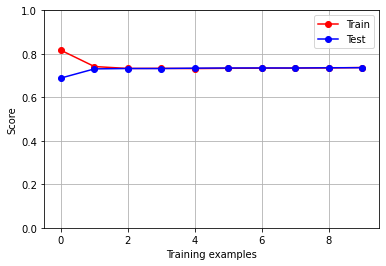

In [72]:
plot_learning_curve(x_train, y_train, ada.best_estimator_)

In [53]:
ada.best_estimator_

AdaBoostClassifier(learning_rate=0.66, n_estimators=100, random_state=42)

AdaBoost has an accuracy of 0.74 and a F1-score of 0.72. While the accuracy is only slightly better than the baseline from above the F1-score is much better. The learning curve indicates that there is no over- or underfitting.

#### K-Nearest Neighbors

The next classifier I will test is the K-Nearest Neighbors:

In [54]:
knc = train_and_evaluate_model(x_train, 
                         y_train, 
                         x_test, 
                         y_test, 
                         KNeighborsClassifier(), 
                         {'n_neighbors': [10,20,50], 'leaf_size': [1, 2, 5]})

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      7442
           1       0.63      0.47      0.54      3603

    accuracy                           0.74     11045
   macro avg       0.70      0.67      0.68     11045
weighted avg       0.72      0.74      0.72     11045



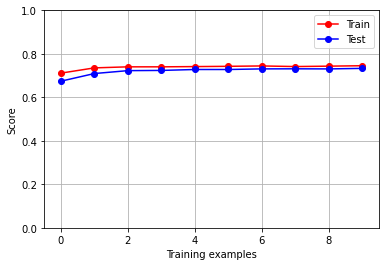

In [55]:
plot_learning_curve(x_train, y_train, knc.best_estimator_)

In [56]:
knc.best_estimator_

KNeighborsClassifier(leaf_size=1, n_neighbors=50)

K-Nearest Neighbors has the same accuracy and F1-score (accuracy: 0.74, F1-score: 0.72) as AdaBoost. The learing curve indicates that there is again under- or overfitting.

#### Random Forest

The third classifier I will test is the Random Forest Classifier.

In [57]:
rfc = train_and_evaluate_model(x_train, 
                         y_train, 
                         x_test, 
                         y_test, 
                         RandomForestClassifier(random_state=42), 
                         {'n_estimators': [1500, 2000], 'min_samples_leaf': [10,15,20]})


              precision    recall  f1-score   support

           0       0.77      0.87      0.82      7442
           1       0.63      0.48      0.55      3603

    accuracy                           0.74     11045
   macro avg       0.70      0.67      0.68     11045
weighted avg       0.73      0.74      0.73     11045



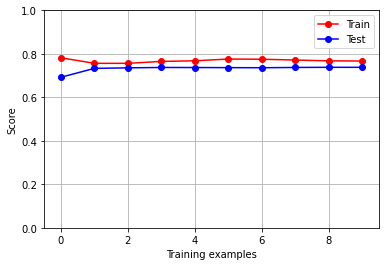

In [58]:
plot_learning_curve(x_train, y_train, rfc.best_estimator_)

In [59]:
rfc.best_estimator_

RandomForestClassifier(min_samples_leaf=15, n_estimators=1500, random_state=42)

The accuracy and F1-score is 0.74 respectively 0.73 while the learning curves of the train and test data are close together and don't indicate any over- or underfitting.

#### Multi-layer Perceptron

The fourth estimator is a MLPClassifier which uses a stochastic gradient descent algorithm:

In [60]:
mlp = train_and_evaluate_model(x_train, 
                         y_train, 
                         x_test, 
                         y_test, 
                         MLPClassifier(random_state=42, max_iter=10000), 
                         {'alpha': [0.01, 0.001, 0.0001]})

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      7442
           1       0.61      0.56      0.58      3603

    accuracy                           0.74     11045
   macro avg       0.70      0.69      0.70     11045
weighted avg       0.73      0.74      0.74     11045



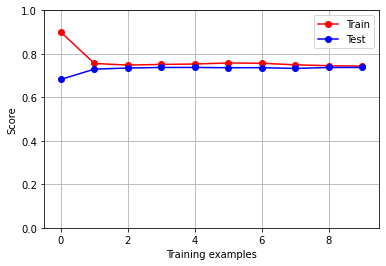

In [61]:
plot_learning_curve(x_train, y_train, mlp.best_estimator_)

In [66]:
mlp.best_estimator_

MLPClassifier(max_iter=10000, random_state=42)

The MLPClassifier has again an accuracy of 0.74 but a slightly better F1-score with 0.74 then the previous tested classifiers. The learning curve looks similar to the previous tested classifiers.

#### C-Support Vector

The last classifier I will use is a C-Support Vector Classification:

In [62]:
svc = train_and_evaluate_model(x_train, 
                         y_train, 
                         x_test, 
                         y_test, 
                         SVC(random_state=42), 
                         {'gamma': [0.25,0.5], 'C': [0.125,0.25]})

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      7442
           1       0.63      0.47      0.54      3603

    accuracy                           0.74     11045
   macro avg       0.70      0.67      0.68     11045
weighted avg       0.73      0.74      0.73     11045



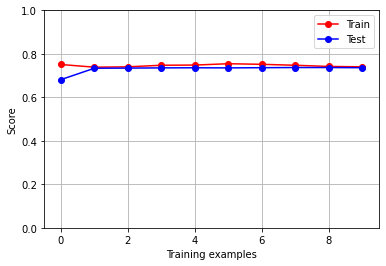

In [63]:
plot_learning_curve(x_train, y_train, svc.best_estimator_)

In [67]:
svc.best_estimator_

SVC(C=0.25, gamma=0.5, random_state=42)

The SVC classifier has an accuracy of 0.74 and a F1-score of 0.73. The learning curve does not show any under- or overfitting.

#### Feature importances

In this last part I will analyze what the most important features are:

In [64]:
feature_importances=pd.DataFrame({'features':x_train.columns,'feature_importance':rfc.best_estimator_.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)

,features,feature_importance
11,income,0.142657
0,reward,0.132045
1,difficulty,0.116725
2,duration,0.112348
10,age,0.107113
8,channel_social,0.102432
5,offer_type_informational,0.087648
20,became_member_on_2018,0.047585
4,offer_type_discount,0.027214
3,offer_type_bogo,0.021066


<AxesSubplot:>

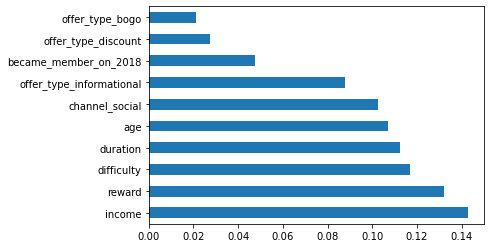

In [65]:
(pd.Series(rfc.best_estimator_.feature_importances_, index=x.columns)
   .nlargest(10)
   .plot(kind='barh'))

Apparently, the most important features referring to a user are income, age and if they became member on 2018 (the most recent date of the data given). The most important features of an offer are reward, difficulty, duration, channel social and the different offer types, although the offer type informational seems to have a much greater impact than the other ones.

# Conclusion

#### Reflection

I chose to predict whether a customer will respond to an offer or not. To achieve this, I had to clean up and prepare the data to be used in a machine learning algorithm. While cleaning up the portfolio and profile data was easy the transaction data was a challenge. Although the data I was interested in was there I had to put a lot of work to bring this data into a structure that allowed me work with it. Based on the transaction data I created a new data frame that holds an entry per user per offer and indicates if the offer was completed or not. Since I was interested in whether the offer had an influence on the user or not I chose to assess an offer as completed only if it was viewed first. Then I merged the portfolio and profile data into the new Dataframe and scaled all non Boolean values.

After the data preprocessing I chose five different classifiers to test. Interestingly, all five classifiers had roughly the same performance. This part was unexpected, although I used grid search to optimize each of the classifiers. Nevertheless I expected at least some variation of accuracy and F1-score. The mediocre scores of accuracy with 0.74 and a F1-score between 0.72 and 0.74 (for MLP) were not unexpected though. The randomness of the data is tricky to deal with: even the same person may respond to the same offer differently on a different day. You just never know when someone wants a up of coffee.

The analysis of the feature importances showed that both customer and offer features are important whether an offer is successful or not. For the customer features income and age are most important and reward, difficulty and duration for the offer features.

#### Improvement

One thing that could be improved is the use of the data given by the event type "transaction". This event is used when a customer buys something and the amount spent is stored. With that data you could either calculate the total amount spent or, in combination with "became_member_on" from the profile data, calculate the average amount spent per month. This might help the classifier to get better results (no guarantee though) or you could exclude customers who already spend much from offers which makes sense from a business perspective. 